In [1]:
import os
import pandas as pd
import numpy as np
import string
from operator import itemgetter
from collections import Counter, OrderedDict

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

from scipy import spatial
import ast

import re
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import gridspec
from math import pi

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.options.mode.chained_assignment = None

### Loading the Relevant Data Files

First up, the dataset with all our wine varieties and their average aroma & nonaroma embeddings.

In [2]:
wine_variety_vectors = pd.read_csv('wine_aromas_nonaromas.csv', index_col='Unnamed: 0')
wine_variety_vectors.head()

,aroma,weight,sweet,acid,salt,piquant,fat,bitter
"Aglianico, Italian Red, Basilicata, Southern Italy, Italy",[ 3.77344441e+00 1.40722466e+00 1.32623768e+...,0.359442,0.124736,0.040592,0.315554,0.462974,0.381428,0.412782
"Aglianico, Italian Red, Campania, Southern Italy, Italy",[ 3.78149199e+00 9.50408936e-01 1.14579260e+...,0.379860,0.225927,0.048268,0.306488,0.469515,0.387027,0.533177
"Alsace white blend, White Blend, Alsace, France",[-4.92766835e-02 3.35418010e+00 3.38098145e+...,0.512093,0.079334,0.009184,0.323208,0.149513,0.457417,0.356811
"Arneis, Italian White, Piedmont, Northwest Italy, Italy",[ 2.21425965e-01 1.00237417e+00 3.36059475e+...,0.580177,0.375782,0.028308,0.325796,0.149979,0.660869,0.718499
"Austrian Red Blend, Red Blends, Burgenland, Austria",[ 2.0704129e+00 2.5170455e+00 8.0864972e-01 ...,0.513533,0.461868,0.023018,0.325831,0.314405,0.396418,0.504508


Before we proceed, we should make sure that the nonaromas are modeled on a scale from low to high for each flavor. At a glance, those for weight, acid, salt and bitter need to be flipped.

In [3]:
wine_variety_vectors['weight'] = wine_variety_vectors['weight'].apply(lambda x: 1 - x)
wine_variety_vectors['acid'] = wine_variety_vectors['acid'].apply(lambda x: 1 - x)
wine_variety_vectors['salt'] = wine_variety_vectors['salt'].apply(lambda x: 1 - x)
wine_variety_vectors['bitter'] = wine_variety_vectors['bitter'].apply(lambda x: 1 - x)

Let's load the other files we'll need:

In [4]:
# a file containing the 50 most frequently appearing descriptors for each wine
descriptor_frequencies = pd.read_csv('wine_variety_descriptors.csv', index_col='index')

# our word2vec model for all wine and food terms
wine_word2vec_model = Word2Vec.load("food_word2vec_model.bin")
word_vectors = wine_word2vec_model.wv 

# a file with the average wine nonaroma vectors for each nonaroma
food_nonaroma_infos = pd.read_csv('average_nonaroma_vectors.csv', index_col='Unnamed: 0')

#### Extracting Nonaroma Values from Food

We will need a method to extract nonaroma values from food. We will compute a value for each nonaroma by looking at the distance between a food's embedding and the embedding that represents each nonaroma. We will normalize this to return a value between 0 and 1. Then, we will further standardize this by mapping the value between 0 and 1 to an ordinal integer value between 1 (low) and 4 (high). 

In [5]:
# this function scales each nonaroma between 0 and 1
def minmax_scaler(val, minval, maxval):
    val = max(min(val, maxval), minval)
    normalized_val = (val - minval)/(maxval - minval)
    return normalized_val

# this function makes sure that a scaled value (between 0 and 1) is returned for a food nonaroma
def check_in_range(label_range_dict, value):
    for label, value_range_tuple in label_range_dict.items():
        lower_end = value_range_tuple[0]
        upper_end = value_range_tuple[1]
        if value >= lower_end and value <= upper_end:
            return label
        else:
            continue

# this function calculates the average word embedding of all foods supplied as input
def calculate_avg_food_vec(sample_foods):
    sample_food_vecs = []
    for s in sample_foods:
        sample_food_vec = word_vectors[s]
        sample_food_vecs.append(sample_food_vec)
    sample_food_vecs_avg = np.average(sample_food_vecs, axis=0)
    return sample_food_vecs_avg

# this function returns two things: a score (between 0 and 1) and a normalized value (integer between 1 and 4) for a given nonaroma
def nonaroma_values(nonaroma, average_food_embedding):
    average_taste_vec = food_nonaroma_infos.at[nonaroma, 'average_vec']
    average_taste_vec = re.sub('\s+', ',', average_taste_vec)
    average_taste_vec = average_taste_vec.replace('[,', '[')
    average_taste_vec  = np.array(ast.literal_eval(average_taste_vec))

    similarity = 1 - spatial.distance.cosine(average_taste_vec, average_food_embedding)
    # scale the similarity using our minmax scaler
    scaled_similarity = minmax_scaler(similarity, food_nonaroma_infos.at[nonaroma, 'farthest'], 
                                      food_nonaroma_infos.at[nonaroma, 'closest'])
    standardized_similarity = check_in_range(food_weights[nonaroma], scaled_similarity)
    similarity_and_scalar = (scaled_similarity, standardized_similarity)
    return similarity_and_scalar

# this function loops through the various nonaromas, returning the nonaroma scores & normalized values, the body/weight of the food and the average food embedding 
def return_all_food_values(sample_foods):
    food_nonaromas = dict()
    average_food_embedding = calculate_avg_food_vec(sample_foods)
    for nonaroma in ['sweet', 'acid', 'salt', 'piquant', 'fat', 'bitter']:
        food_nonaromas[nonaroma] = nonaroma_values(nonaroma, average_food_embedding)
    food_weight = nonaroma_values('weight', average_food_embedding)
    return food_nonaromas, food_weight, average_food_embedding

In [6]:
# this is the mapping of food similarities to the normalized ordinal integer values between 1 and 4
food_weights = {
    'weight': {1: (0, 0.3), 2: (0.3, 0.5), 3: (0.5, 0.7), 4: (0.7, 1)},
    'sweet': {1: (0, 0.45), 2: (0.45, 0.6), 3: (0.6, 0.8), 4: (0.8, 1)},
    'acid': {1: (0, 0.4), 2: (0.4, 0.55), 3: (0.55, 0.7), 4: (0.7, 1)},
    'salt': {1: (0, 0.3), 2: (0.3, 0.55), 3: (0.55, 0.8), 4: (0.8, 1)},
    'piquant': {1: (0, 0.4), 2: (0.4, 0.6), 3: (0.6, 0.8), 4: (0.8, 1)},
    'fat': {1: (0, 0.4), 2: (0.4, 0.5), 3: (0.5, 0.6), 4: (0.6, 1)},
    'bitter': {1: (0, 0.3), 2: (0.3, 0.5), 3: (0.5, 0.65), 4: (0.65, 1)}
}

### Standardizing Nonaroma Values from Wine

To compare the nonaroma characteristics of wines and foods, we need to normalize them on the same scale (1-4).

In [7]:
wine_weights = {
    'weight': {1: (0, 0.25), 2: (0.25, 0.45), 3: (0.45, 0.75), 4: (0.75, 1)},
    'sweet': {1: (0, 0.25), 2: (0.25, 0.6), 3: (0.6, 0.75), 4: (0.75, 1)},
    'acid': {1: (0, 0.05), 2: (0.05, 0.25), 3: (0.25, 0.5), 4: (0.5, 1)},
    'salt': {1: (0, 0.15), 2: (0.15, 0.25), 3: (0.25, 0.7), 4: (0.7, 1)},
    'piquant': {1: (0, 0.15), 2: (0.15, 0.3), 3: (0.3, 0.6), 4: (0.6, 1)},
    'fat': {1: (0, 0.25), 2: (0.25, 0.5), 3: (0.5, 0.7), 4: (0.7, 1)},
    'bitter': {1: (0, 0.2), 2: (0.2, 0.37), 3: (0.37, 0.6), 4: (0.6, 1)}
}
            
wine_variety_vectors_normalized = wine_variety_vectors.copy()
for w, subdict in wine_weights.items():
    wine_variety_vectors_normalized[w] = wine_variety_vectors_normalized[w].apply(lambda x: check_in_range(subdict, x))

wine_variety_vectors_normalized.sort_index(inplace=True)

### Pairing Rules

Now, we will set some rules for creating wine pairings. We will run the rules below sequentially to eliminate pairings that do not make sense. 

In [8]:
def weight_rule(df, food_weight):
    # Rule 1: the wine should have at least the same body as the food
    df = df.loc[(df['weight'] >= food_weight[1] - 1) & (df['weight'] <= food_weight[1])]
    return df

def acidity_rule(df, food_nonaromas):
    # Rule 2: the wine should be at least as acidic as the food
    df = df.loc[df['acid'] >= food_nonaromas['acid'][1]]
    return df

def sweetness_rule(df, food_nonaromas):
    # Rule 3: the wine should be at least as sweet as the food
    df = df.loc[df['sweet'] >= food_nonaromas['sweet'][1]]
    return df

def bitterness_rule(df, food_nonaromas):
    # Rule 4: bitter wines do not pair well with bitter foods 
    if food_nonaromas['bitter'][1] == 4:
        df = df.loc[df['bitter'] <= 2]
    return df

def bitter_salt_rule(df, food_nonaromas):
    # Rule 5: bitter and salt do not go well together
    if food_nonaromas['bitter'][1] == 4:
        df = df.loc[(df['salt'] <= 2)]
    if food_nonaromas['salt'] == 4:
        df = df.loc[(df['bitter'][1] <= 2)]
    return df
    
def acid_bitter_rule(df, food_nonaromas):
    # Rule 6: acid and bitterness do not go well together
    if food_nonaromas['acid'][1] == 4:
        df = df.loc[(df['bitter'] <= 2)]
    if food_nonaromas['bitter'][1] == 4:
        df = df.loc[(df['acid'] <= 2)]
    return df

def acid_piquant_rule(df, food_nonaromas):
    # Rule 7: acid and piquant do not go well together
    if food_nonaromas['acid'][1] == 4:
        df = df.loc[(df['piquant'] <= 2)]
    if food_nonaromas['piquant'][1] == 4:
        df = df.loc[(df['acid'] <= 2)]
    return df

def nonaroma_rules(wine_df, food_nonaromas, food_weight):
    df = weight_rule(wine_df, food_weight)
    list_of_tests = [acidity_rule, sweetness_rule, bitterness_rule, bitter_salt_rule, acid_bitter_rule, acid_piquant_rule]
    for t in list_of_tests:
        # only apply the rule if it retains a sufficient number of wines in the selection.
        df_test = t(df, food_nonaromas)
        if df_test.shape[0] > 5:
            df = t(df, food_nonaromas)
#         print(df.shape)
    return df


Now, we would like to find which pairings are contrasting or congruent. Contrasting pairings have nonaroma attributes that are different but that match well, whereas congruent pairings make use of shared compounds between wine and food. 

In [9]:
def sweet_pairing(df, food_nonaromas):
    # Rule 1: sweet food goes well with highly bitter, fat, piquant, salt or acid wine
    if food_nonaromas['sweet'][1] == 4:
        df['pairing_type'] = np.where(((df.bitter == 4) | (df.fat == 4) | (df.piquant == 4) | (df.salt == 4) | (df.acid == 4)), 'contrasting', df.pairing_type)
    return df

def acid_pairing(df, food_nonaromas):
    # Rule 2: acidic food goes well with highly sweet, fat, or salt wine
    if food_nonaromas['acid'][1] == 4:
        df['pairing_type'] = np.where(((df.sweet == 4) | (df.fat == 4) | (df.salt == 4)), 'contrasting', df.pairing_type)
    return df

def salt_pairing(df, food_nonaromas):
    # Rule 3: sweet food goes well with highly bitter, fat, piquant, salt or acid wine
    if food_nonaromas['salt'][1] == 4:
        df['pairing_type'] = np.where(((df.bitter == 4) | (df.sweet == 4) | (df.piquant == 4) | (df.fat == 4) | (df.acid == 4)), 'contrasting', df.pairing_type)
    return df

def piquant_pairing(df, food_nonaromas):
    # Rule 4: piquant food goes well with highly sweet, fat, or salt wine
    if food_nonaromas['piquant'][1] == 4:
        df['pairing_type'] = np.where(((df.sweet == 4) | (df.fat == 4) | (df.salt == 4)), 'contrasting', df.pairing_type)
    return df

def fat_pairing(df, food_nonaromas):
    # Rule 5: fatty food goes well with highly bitter, fat, piquant, salt or acid wine
    if food_nonaromas['fat'][1] == 4:
        df['pairing_type'] = np.where(((df.bitter == 4) | (df.sweet == 4) | (df.piquant == 4) | (df.salt == 4) | (df.acid == 4)), 'contrasting', df.pairing_type)
    return df

def bitter_pairing(df, food_nonaromas):
    # Rule 6: bitter food goes well with highly sweet, fat, or salt wine
    if food_nonaromas['bitter'][1] == 4:
        df['pairing_type'] = np.where(((df.sweet == 4) | (df.fat == 4) | (df.salt == 4)), 'contrasting', df.pairing_type)
    return df

def congruent_pairing(pairing_type, max_food_nonaroma_val, wine_nonaroma_val):
    if pairing_type == 'congruent':
        return 'congruent'
    elif wine_nonaroma_val >= max_food_nonaroma_val:
        return 'congruent'
    else:
        return ''
    
def congruent_or_contrasting(df, food_nonaromas):
    
    # first, look for a congruent match
    max_nonaroma_val = max([i[1] for i in list(food_nonaromas.values())])
    most_defining_tastes = [key for key, val in food_nonaromas.items() if val[1] == max_nonaroma_val]
    df['pairing_type'] = ''
    for m in most_defining_tastes:
        df['pairing_type'] = df.apply(lambda x: congruent_pairing(x['pairing_type'], food_nonaromas[m][1], x[m]), axis=1)

    # then, look for any contrasting matches
    list_of_tests = [sweet_pairing, acid_pairing, salt_pairing, piquant_pairing, fat_pairing, bitter_pairing]
    for t in list_of_tests:
        df = t(df, food_nonaromas)
    return df

Finally, we will prioritize wine recommendations that share aroma characteristics with the food. We will sort the resulting recommendations by similarity between the wine aroma embedding and the average food embedding, in descending order. 

In [10]:
def sort_by_aroma_similarity(df, food_aroma):
    
    def nparray_str_to_list(array_string):
        average_taste_vec = re.sub('\s+', ',', array_string)
        average_taste_vec = average_taste_vec.replace('[,', '[')
        average_taste_vec  = np.array(ast.literal_eval(average_taste_vec))
        return average_taste_vec
    
    df['aroma'] = df['aroma'].apply(nparray_str_to_list)
    df['aroma_distance'] = df['aroma'].apply(lambda x: spatial.distance.cosine(x, food_aroma))
    df.sort_values(by=['aroma_distance'], ascending=True, inplace=True)
    return df

For the top wine recommendations, we would also like to have a bit of additional context on which aroma descriptors in the wine match well with our food. 

In [11]:
# these functions return the wine descriptors that most closely match the wine aromas of the selected recommendations. This will help give additional context and justification to the recommendations.

def find_descriptor_distance(word, foodvec):
    descriptor_wordvec = word_vectors[word]
    similarity = 1 - spatial.distance.cosine(descriptor_wordvec, foodvec)
    return similarity

def most_impactful_descriptors(recommendation):
    recommendation_frequencies = descriptor_frequencies.filter(like=recommendation, axis=0)
    recommendation_frequencies['similarity'] = recommendation_frequencies['descriptors'].apply(lambda x: find_descriptor_distance(x, aroma_embedding))    
    recommendation_frequencies.sort_values(['similarity', 'relative_frequency'], ascending=False, inplace=True)
    recommendation_frequencies = recommendation_frequencies.head(5)
    most_impactful_descriptors = list(recommendation_frequencies['descriptors'])
    return most_impactful_descriptors

The following function puts all the steps in our recommendation generation process together.

In [12]:
def retrieve_pairing_type_info(wine_recommendations, full_nonaroma_table, pairing_type):
    pairings = wine_recommendations.loc[wine_recommendations['pairing_type'] == pairing_type].head(4)
    wine_names = list(pairings.index)
    recommendation_nonaromas = full_nonaroma_table.loc[wine_names, :]
    pairing_nonaromas = recommendation_nonaromas[['sweet', 'acid', 'salt', 'piquant', 'fat', 'bitter']].to_dict('records')
    pairing_body = list(recommendation_nonaromas['weight'])
    impactful_descriptors = list(pairings['most_impactful_descriptors'])
    return wine_names, pairing_nonaromas, pairing_body, impactful_descriptors

### Visualization

We will want to examine the proposed recommendations in a visual manner. The following cells lay out functions that we can use to generate a visualization of the food nonaromas, and subsequently nonaroma & aroma details for a series of wine recommendations.

In [13]:
def make_spider(gs, n, data, title, color, pairing_type):
    
    # number of variable
    categories = list(food_nonaromas.keys())
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(gs[n], polar=True, )

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=11)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0.25, 0.5, 0.75, 1.0], ["0.25","0.50","0.75", "1.00"], color="grey", size=0)
    plt.ylim(0, 1)

    # Ind1
    values = list(data.values())
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    # Add a title
    # Insert a line break in the title if needed
    title_split = str(title).split(',')
    new_title = []
    for number, word in enumerate(title_split):
        if (number % 2) == 0 and number > 0:
            updated_word = '\n' + word.strip()
            new_title.append(updated_word)
        else:
            updated_word = word.strip()
            new_title.append(updated_word)
    new_title = ', '.join(new_title)
    
    title_incl_pairing_type = new_title + '\n' + '(' + str(pairing_type) + ')'
    
    plt.title(title_incl_pairing_type, size=13, color='black', y=1.2)

In [14]:
def plot_number_line(gs, n, value, dot_color):
    ax = plt.subplot(gs[n])
    ax.set_xlim(-1, 2)
    ax.set_ylim(0, 3)

    # draw lines
    xmin = 0
    xmax = 1
    y = 1
    height = 0.2

    plt.hlines(y, xmin, xmax)
    plt.vlines(xmin, y - height / 2., y + height / 2.)
    plt.vlines(xmax, y - height / 2., y + height / 2.)

    # draw a point on the line
    px = value
    plt.plot(px, y, 'ko', ms = 10, mfc = dot_color)

    # add numbers
    plt.text(xmin - 0.1, y, 'Light-Bodied', horizontalalignment='right', fontsize=11, color='grey')
    plt.text(xmax + 0.1, y, 'Full-Bodied', horizontalalignment='left', fontsize=11, color='grey')

    plt.axis('off')

In [15]:
def create_text(gs, n, impactful_descriptors):
    ax = plt.subplot(gs[n])
    
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.invert_yaxis()
    
    text = f'Complementary wine aromas:\n\n{impactful_descriptors[0]}, \n{impactful_descriptors[1]}, \n{impactful_descriptors[2]}, \n{impactful_descriptors[3]}, \n{impactful_descriptors[4]}'
    ax.text(x=0, y=1, s=text, fontsize=12, color='grey')

In [16]:
def plot_wine_recommendations(pairing_wines, pairing_nonaromas, pairing_body, impactful_descriptors, pairing_types):

    subplot_rows = 3
    subplot_columns = 4
    plt.figure(figsize=(20, 7), dpi=96)

    gs = gridspec.GridSpec(3, 4, height_ratios=[3, 0.5, 1]) 

    spider_nr = 0
    number_line_nr = 4
    descriptor_nr = 8

    for w in range(4):
        make_spider(gs, spider_nr, pairing_nonaromas[w], pairing_wines[w], 'red', pairing_types[w])
        plot_number_line(gs, number_line_nr, pairing_body[w], dot_color='red')
        create_text(gs, descriptor_nr, impactful_descriptors[w])
        spider_nr += 1
        number_line_nr += 1
        descriptor_nr += 1

It's showtime. Time to generate our wine recommendations.

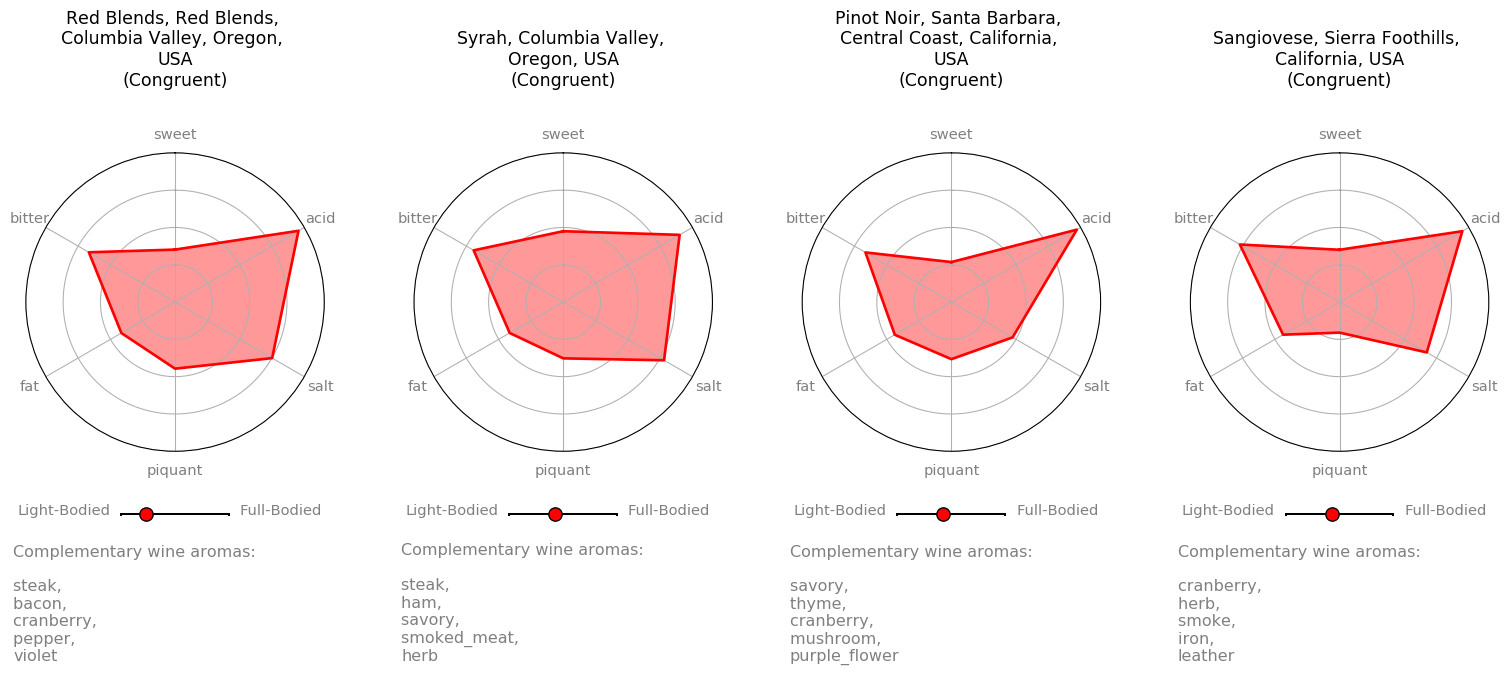

In [106]:
test_food = ['hotdog', 'mustard', 'tomato', 'onion', 'pepperoncini', 'gherkin', 'celery', 'relish']
appetizer = ['trout', 'dill', 'cucumber', 'sour_cream']
entree = ['roast_chicken', 'tarragon', 'sage']
dessert = ['peach', 'pie']

food_nonaromas, food_weight, aroma_embedding = return_all_food_values(dessert)

wine_recommendations = wine_variety_vectors_normalized.copy()
wine_recommendations = nonaroma_rules(wine_recommendations, food_nonaromas, food_weight)
wine_recommendations = congruent_or_contrasting(wine_recommendations, food_nonaromas)
wine_recommendations = sort_by_aroma_similarity(wine_recommendations, aroma_embedding)
wine_recommendations['most_impactful_descriptors'] = wine_recommendations.index.map(most_impactful_descriptors)

# see if there are any contrasting suggestions
try:
    contrasting_wines, contrasting_nonaromas, contrasting_body, impactful_descriptors_contrasting = retrieve_pairing_type_info(wine_recommendations, wine_variety_vectors, 'contrasting')
except:
    contrasting_wines = []

try:
    congruent_wines, congruent_nonaromas, congruent_body, impactful_descriptors_congruent = retrieve_pairing_type_info(wine_recommendations, wine_variety_vectors, 'congruent')
except:
    congruent_wines = []

# if possible, provide 2 contrasting and 2 congruent options. If not possible, just return 4 options of one type.
if len(contrasting_wines) >= 2 and len(congruent_wines) >= 2:
    wine_names = contrasting_wines[:2] + congruent_wines[:2]
    wine_nonaromas = contrasting_nonaromas[:2] + congruent_nonaromas[:2]
    wine_body = contrasting_body[:2] + congruent_body[:2]
    impactful_descriptors = impactful_descriptors_contrasting[:2] + impactful_descriptors_congruent[:2]
    pairing_types = ['Contrasting', 'Contrasting', 'Congruent', 'Congruent']
elif len(contrasting_wines) >= 2:
    wine_names = contrasting_wines
    wine_nonaromas = contrasting_nonaromas
    wine_body = contrasting_body
    impactful_descriptors = impactful_descriptors_contrasting
    pairing_types = ['Contrasting', 'Contrasting', 'Contrasting', 'Contrasting']
else:
    wine_names = congruent_wines
    wine_nonaromas = congruent_nonaromas
    wine_body = congruent_body
    impactful_descriptors = impactful_descriptors_congruent
    pairing_types = ['Congruent', 'Congruent', 'Congruent', 'Congruent']

plot_wine_recommendations(wine_names, wine_nonaromas, wine_body, impactful_descriptors, pairing_types)

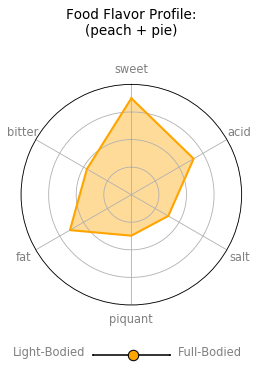

In [105]:
plt.figure(figsize=(4, 5), dpi=75)

gs = gridspec.GridSpec(2, 1, height_ratios=[3, 0.5]) 

food_nonaromas_norm = {k: v[0] for k, v in food_nonaromas.items()}

food_names = ' + '.join(dessert)
make_spider(gs, 0, food_nonaromas_norm, 'Food Flavor Profile:', 'orange', food_names)
plot_number_line(gs, 1, food_weight[0], dot_color='orange')

In [92]:
print(food_nonaromas_norm)

{'sweet': 0.4613773048272533, 'acid': 0.8096417023389532, 'salt': 0.9014882479880785, 'piquant': 0.695169140975374, 'fat': 0.610969409566638, 'bitter': 0.5461646921026969}
